In [9]:
import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import clip
import os
import sys
import matplotlib.pyplot as plt
# sys.path.append(os.path.abspath("/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/src/codebase"))

# # from breastclip.data.data_utils import load_tokenizer
# from breastclip.model import BreastClip
# from cxrclip.data import DataModule
# from cxrclip.model import CXRClip, build_model

In [23]:
def get_sentences_for_err_slices(
        df_fold_corr_indx, df_fold_incorr_indx, clf_image_emb_path, aligner_path,
        keyword, clip_model
):
    keyword_tokens = clip.tokenize(keyword).to(device)
    keyword_features = clip_model.encode_text(keyword_tokens).mean(dim=0, keepdim=True)
    img_emb_clf = np.load(clf_image_emb_path)
    img_emb_clf_corr = img_emb_clf[df_fold_corr_indx]
    img_emb_clf_incorr = img_emb_clf[df_fold_incorr_indx]


    aligner = torch.load(aligner_path)
    W = aligner["W"].to(device)
    b = aligner["b"].to(device)

    img_emb_clf_corr_tensor = torch.from_numpy(img_emb_clf_corr).to(device)
    img_emb_clip_corr_tensor = img_emb_clf_corr_tensor @ W.T + b

    img_emb_clip_corr_tensor = img_emb_clip_corr_tensor.float()
    keyword_features = keyword_features.float()
    sim_corr = torch.matmul(img_emb_clip_corr_tensor, keyword_features.T)
    sim_corr_mean = torch.mean(sim_corr, dim=0)


    img_emb_clf_incorr_tensor = torch.from_numpy(img_emb_clf_incorr).to(device)
    img_emb_clip_incorr_tensor = img_emb_clf_incorr_tensor @ W.T + b
    img_emb_clip_incorr_tensor = img_emb_clip_incorr_tensor.float()
    keyword_features = keyword_features.float()
    sim_incorr = torch.matmul(img_emb_clip_incorr_tensor, keyword_features.T)
    sim_incorr_mean = torch.mean(sim_incorr, dim=0)
    clip_score = sim_corr_mean - sim_incorr_mean
    return clip_score.item() *100

## Waterbirds - waterbird

In [38]:
# Waterbirds- waterbird
# clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_clip_embeddings.npy"
clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_classifier_embeddings.npy"
aligner_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/aligner_30.pth"
clf_results_csv="/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_additional_info.csv"
result = {}
data = ['Dock', 'Boat', 'Sunset', 'Flying', 'Sitting', 'Ocean', 'Lake', 'Cloudy sky']
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
pred_col = "Predictions_bin"
df = pd.read_csv(clf_results_csv)
df[pred_col] = (df["out_put_predict"] >= 0.5).astype(int)
df_corr_indx = df[(df["out_put_GT"] == 1) & (df[pred_col] == 1)].index.tolist()
df_incorr_indx = df[(df["out_put_GT"] == 1) & (df[pred_col] == 0)].index.tolist()

In [39]:
for keyword in data:
    clip_score = get_sentences_for_err_slices(
        df_corr_indx, df_incorr_indx, clf_image_emb_path, aligner_path,
        keyword.lower(), clip_model
    )
    result[keyword] = clip_score
result

{'Dock': 22.57373332977295,
 'Boat': 26.11759901046753,
 'Sunset': 14.822649955749512,
 'Flying': 8.67164134979248,
 'Sitting': 10.10143756866455,
 'Ocean': 30.536699295043945,
 'Lake': 24.02021884918213,
 'Cloudy sky': 12.640106678009033}

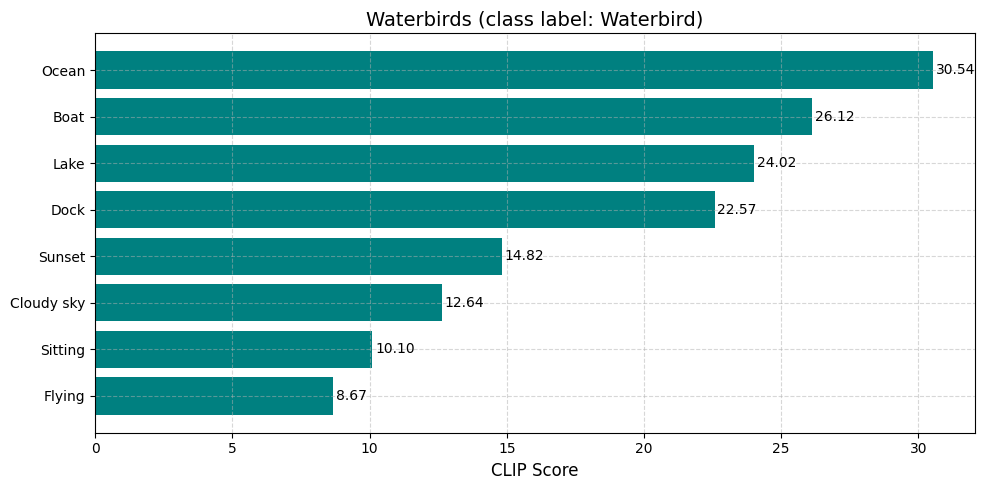

In [40]:
title_font_size = 14
axis_label_font_size = 12
ticks_font_size = 10

sorted_results = sorted(result.items(), key=lambda x: x[1])

# Extracting keys and values
categories = [x[0] for x in sorted_results]
values = [x[1] for x in sorted_results]

# Creating the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(categories, values, color='teal')  # Using a bright blue color for better visual appeal
ax.set_xlabel('CLIP Score', fontsize=axis_label_font_size)
ax.set_title('Waterbirds (class label: Waterbird)', fontsize=title_font_size)

ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax.grid(True, linestyle='--', which='both', alpha=0.5)
# Adding the numbers on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  # Slight offset to the right for the label to not overlap with the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig('Plots/waterbirds_waterbird_clip_score.png', dpi=500)
plt.show()

## Waterbirds- landbird

In [41]:
# clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_clip_embeddings.npy"
clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_classifier_embeddings.npy"
aligner_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/aligner_30.pth"
clf_results_csv="/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_additional_info.csv"
result = {}
data = ['Bamboo forest', 'Yellow color', 'Tree branch', 'Flying', 'Tree top']

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
pred_col = "Predictions_bin"
df = pd.read_csv(clf_results_csv)
df[pred_col] = (df["out_put_predict"] >= 0.5).astype(int)
df_corr_indx = df[(df["out_put_GT"] == 0) & (df[pred_col] == 0)].index.tolist()
df_incorr_indx = df[(df["out_put_GT"] == 0) & (df[pred_col] == 1)].index.tolist()

In [42]:
for keyword in data:
    clip_score = get_sentences_for_err_slices(
        df_corr_indx, df_incorr_indx, clf_image_emb_path, aligner_path,
        keyword.lower(), clip_model
    )
    result[keyword] = clip_score
result

{'Bamboo forest': 25.257432460784912,
 'Yellow color': 7.603943347930908,
 'Tree branch': 17.71864891052246,
 'Flying': -5.972886085510254,
 'Tree top': 21.181702613830566}

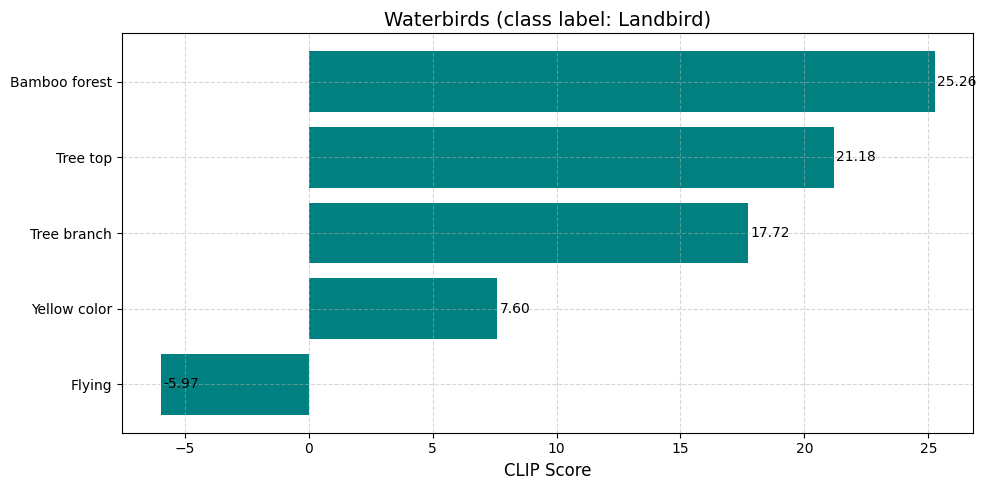

In [43]:
title_font_size = 14
axis_label_font_size = 12
ticks_font_size = 10

sorted_results = sorted(result.items(), key=lambda x: x[1])

# Extracting keys and values
categories = [x[0] for x in sorted_results]
values = [x[1] for x in sorted_results]

# Creating the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(categories, values, color='teal')  # Using a bright blue color for better visual appeal
ax.set_xlabel('CLIP Score', fontsize=axis_label_font_size)
ax.set_title('Waterbirds (class label: Landbird)', fontsize=title_font_size)

ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax.grid(True, linestyle='--', which='both', alpha=0.5)
# Adding the numbers on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  # Slight offset to the right for the label to not overlap with the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig('Plots/waterbirds_landbird_clip_score.png', dpi=500)
plt.show()

## CelebA - Blonde

In [35]:
# clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_clip_embeddings.npy"
clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/CelebA/resnet_sup_in1k_attrNo/CelebA_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_classifier_embeddings.npy"
aligner_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/CelebA/resnet_sup_in1k_attrNo/CelebA_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/aligner_30.pth"
clf_results_csv="/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/CelebA/resnet_sup_in1k_attrNo/CelebA_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_additional_info.csv"
result = {}
data = ['Women with long hair', 'Women with black top', 'Women wearing red dress', 
        'Women wearing blue dress', 'Women with blue eyes']

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
pred_col = "Predictions_bin"
df = pd.read_csv(clf_results_csv)
df[pred_col] = (df["out_put_predict"] >= 0.5).astype(int)
df_corr_indx = df[(df["out_put_GT"] == 1) & (df[pred_col] == 1)].index.tolist()
df_incorr_indx = df[(df["out_put_GT"] == 1) & (df[pred_col] == 0)].index.tolist()

In [36]:
for keyword in data:
    clip_score = get_sentences_for_err_slices(
        df_corr_indx, df_incorr_indx, clf_image_emb_path, aligner_path,
        keyword.lower(), clip_model
    )
    result[keyword] = clip_score
result

{'Women with long hair': 5.934786796569824,
 'Women with black top': 8.072388172149658,
 'Women wearing red dress': 8.20932388305664,
 'Women wearing blue dress': 7.646298408508301,
 'Women with blue eyes': 10.544395446777344}

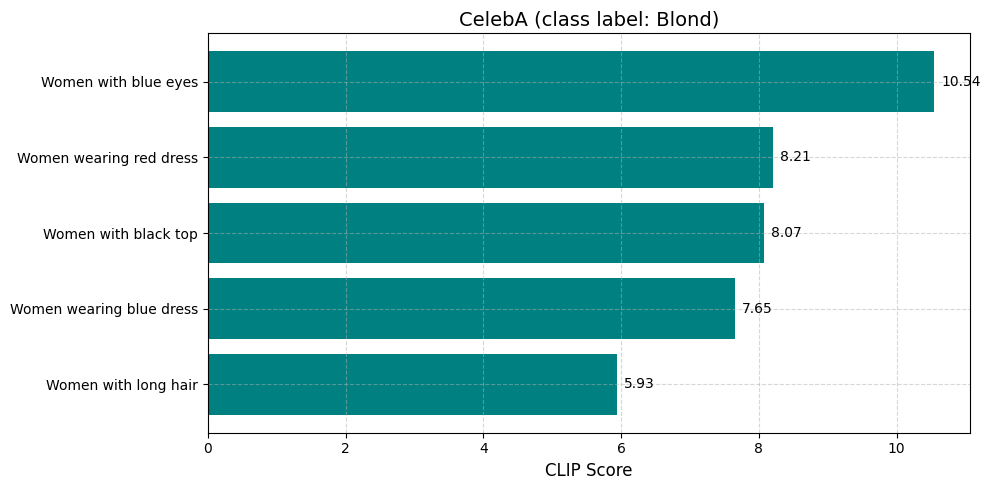

In [37]:
title_font_size = 14
axis_label_font_size = 12
ticks_font_size = 10

sorted_results = sorted(result.items(), key=lambda x: x[1])

# Extracting keys and values
categories = [x[0] for x in sorted_results]
values = [x[1] for x in sorted_results]

# Creating the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(categories, values, color='teal')  # Using a bright blue color for better visual appeal
ax.set_xlabel('CLIP Score', fontsize=axis_label_font_size)
ax.set_title('CelebA (class label: Blond)', fontsize=title_font_size)

ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax.grid(True, linestyle='--', which='both', alpha=0.5)
# Adding the numbers on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  # Slight offset to the right for the label to not overlap with the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig('Plots/CelebA_blond_clip_score.png', dpi=500)
plt.show()

## MetaShif - Cat

In [32]:
# clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_clip_embeddings.npy"
clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out//MetaShift/resnet_sup_in1k_attrNo/MetaShift_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_classifier_embeddings.npy"
aligner_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out//MetaShift/resnet_sup_in1k_attrNo//MetaShift_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/aligner_30.pth"
clf_results_csv="/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out//MetaShift/resnet_sup_in1k_attrNo//MetaShift_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_additional_info.csv"
result = {}
data = ['Latops', 'Batroom settings', 'Beds', 'Desks', 'Sink']


device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
pred_col = "Predictions_bin"
df = pd.read_csv(clf_results_csv)
df[pred_col] = (df["out_put_predict"] >= 0.5).astype(int)
df_corr_indx = df[(df["out_put_GT"] == 1) & (df[pred_col] == 1)].index.tolist()
df_incorr_indx = df[(df["out_put_GT"] == 1) & (df[pred_col] == 0)].index.tolist()


In [33]:
for keyword in data:
    clip_score = get_sentences_for_err_slices(
        df_corr_indx, df_incorr_indx, clf_image_emb_path, aligner_path,
        keyword.lower(), clip_model
    )
    result[keyword] = clip_score
result

{'Latops': 17.4832820892334,
 'Batroom settings': 7.077217102050781,
 'Beds': 6.025850772857666,
 'Desks': 8.490145206451416,
 'Sink': 22.45156764984131}

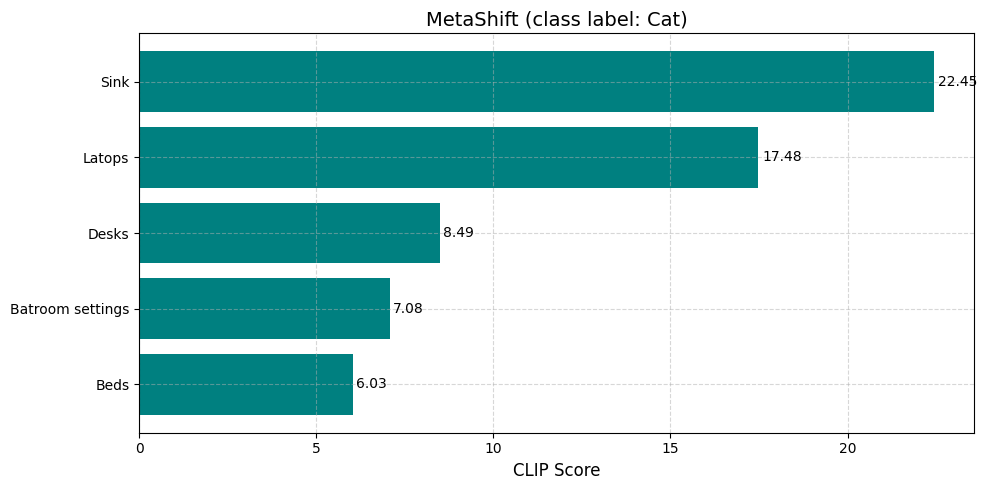

In [34]:
title_font_size = 14
axis_label_font_size = 12
ticks_font_size = 10

sorted_results = sorted(result.items(), key=lambda x: x[1])

# Extracting keys and values
categories = [x[0] for x in sorted_results]
values = [x[1] for x in sorted_results]

# Creating the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(categories, values, color='teal')  # Using a bright blue color for better visual appeal
ax.set_xlabel('CLIP Score', fontsize=axis_label_font_size)
ax.set_title('MetaShift (class label: Cat)', fontsize=title_font_size)

ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax.grid(True, linestyle='--', which='both', alpha=0.5)
# Adding the numbers on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  # Slight offset to the right for the label to not overlap with the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig('Plots/metashift_cat_clip_score.png', dpi=500)
plt.show()

## MetaShif - Dog

In [27]:
# clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out/Waterbirds/resnet_sup_in1k_attrNo/Waterbirds_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_clip_embeddings.npy"
clf_image_emb_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out//MetaShift/resnet_sup_in1k_attrNo/MetaShift_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_classifier_embeddings.npy"
aligner_path = "/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out//MetaShift/resnet_sup_in1k_attrNo//MetaShift_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/aligner_30.pth"
clf_results_csv="/restricted/projectnb/batmanlab/shawn24/PhD/Multimodal-mistakes-debug/out//MetaShift/resnet_sup_in1k_attrNo//MetaShift_ERM_hparams0_seed0/clip_img_encoder_ViT-B/32/test_additional_info.csv"
result = {}
data = ['Sport equipment', 'Beaches', 'Motion', 'Objects in their mouths', 'Leashes']


device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
pred_col = "Predictions_bin"
df = pd.read_csv(clf_results_csv)
df[pred_col] = (df["out_put_predict"] >= 0.5).astype(int)
df_corr_indx = df[(df["out_put_GT"] == 0) & (df[pred_col] == 0)].index.tolist()
df_incorr_indx = df[(df["out_put_GT"] == 0) & (df[pred_col] == 1)].index.tolist()


In [28]:
for keyword in data:
    clip_score = get_sentences_for_err_slices(
        df_corr_indx, df_incorr_indx, clf_image_emb_path, aligner_path,
        keyword.lower(), clip_model
    )
    result[keyword] = clip_score
result

{'Sport equipment': 10.365724563598633,
 'Beaches': 13.380098342895508,
 'Motion': 11.18936538696289,
 'Objects in their mouths': 3.1514763832092285,
 'Leashes': 23.172545433044434}

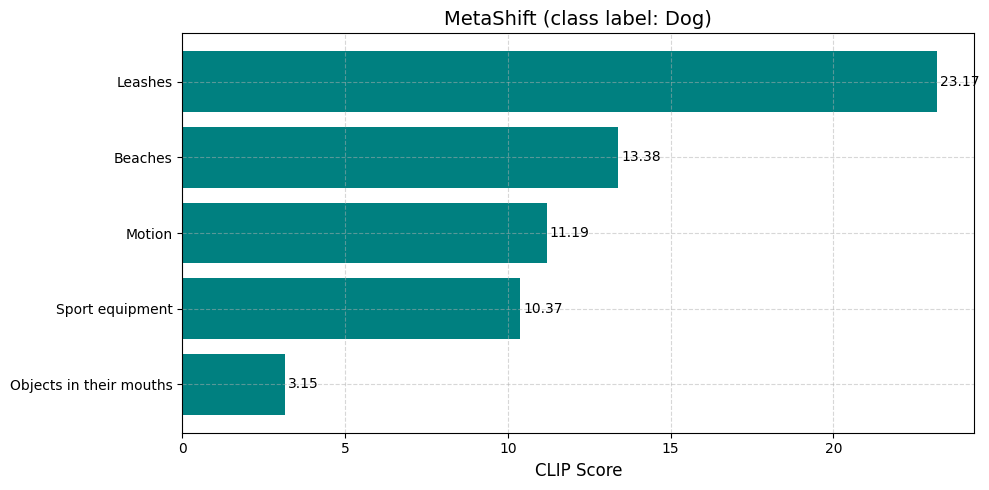

In [29]:
title_font_size = 14
axis_label_font_size = 12
ticks_font_size = 10

sorted_results = sorted(result.items(), key=lambda x: x[1])

# Extracting keys and values
categories = [x[0] for x in sorted_results]
values = [x[1] for x in sorted_results]

# Creating the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(categories, values, color='teal')  # Using a bright blue color for better visual appeal
ax.set_xlabel('CLIP Score', fontsize=axis_label_font_size)
ax.set_title('MetaShift (class label: Dog)', fontsize=title_font_size)

ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax.grid(True, linestyle='--', which='both', alpha=0.5)
# Adding the numbers on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  # Slight offset to the right for the label to not overlap with the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig('Plots/metashift_dog_clip_score.png', dpi=500)
plt.show()

## NIH

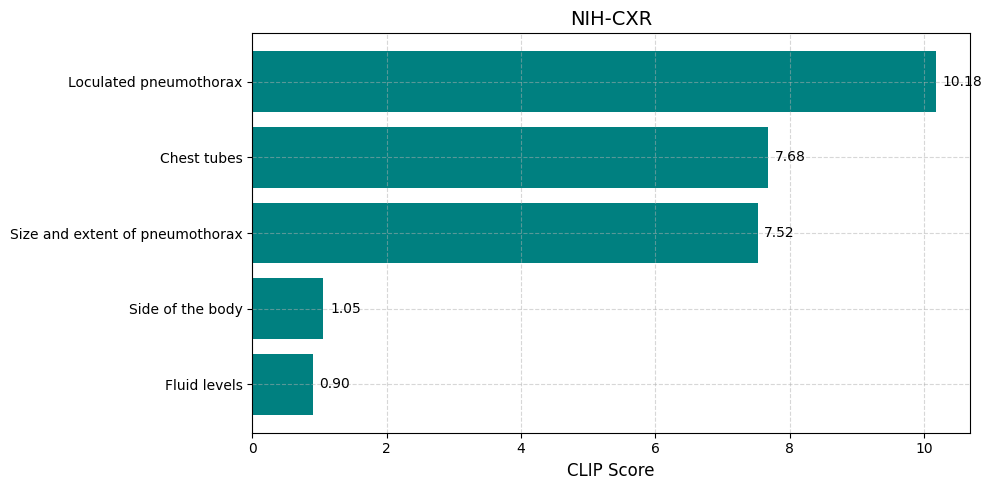

In [30]:
result = {
    'Loculated pneumothorax': 10.176192224025726, 
    'Chest tubes': 7.6798707246780396, 
    'Fluid levels': 0.8993074297904968, 
    'Size and extent of pneumothorax': 7.523186504840851, 
    'Side of the body': 1.0538533329963684
}
title_font_size = 14
axis_label_font_size = 12
ticks_font_size = 10

sorted_results = sorted(result.items(), key=lambda x: x[1])

# Extracting keys and values
categories = [x[0] for x in sorted_results]
values = [x[1] for x in sorted_results]

# Creating the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(categories, values, color='teal')  # Using a bright blue color for better visual appeal
ax.set_xlabel('CLIP Score', fontsize=axis_label_font_size)
ax.set_title('NIH-CXR', fontsize=title_font_size)

ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax.grid(True, linestyle='--', which='both', alpha=0.5)
# Adding the numbers on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  # Slight offset to the right for the label to not overlap with the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig('Plots/nih_pneumothorax_clip_score.png', dpi=500)
plt.show()

## RSNA

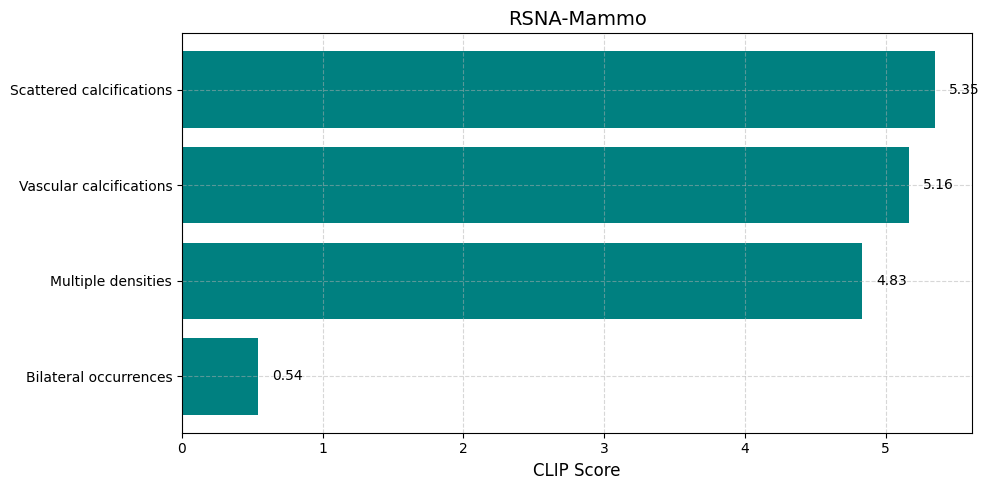

In [31]:
result = {
    'Scattered calcifications': 5.349567160010338, 
    'Bilateral occurrences': 0.5406413227319717,
    'Multiple densities': 4.831770434975624, 
    'Vascular calcifications': 5.1635101437568665
}

title_font_size = 14
axis_label_font_size = 12
ticks_font_size = 10

sorted_results = sorted(result.items(), key=lambda x: x[1])

# Extracting keys and values
categories = [x[0] for x in sorted_results]
values = [x[1] for x in sorted_results]

# Creating the horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(categories, values, color='teal')  # Using a bright blue color for better visual appeal
ax.set_xlabel('CLIP Score', fontsize=axis_label_font_size)
ax.set_title('RSNA-Mammo', fontsize=title_font_size)

ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)
ax.grid(True, linestyle='--', which='both', alpha=0.5)
# Adding the numbers on top of each bar
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.1  # Slight offset to the right for the label to not overlap with the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

plt.tight_layout()
plt.savefig('Plots/rsna_cancer_clip_score.png', dpi=500)
plt.show()